# Autoregressive Moving Average (ARMA): Sunspots data

This notebook replicates the existing ARMA notebook using the `statsmodels.tsa.statespace.SARIMAX` class rather than the `statsmodels.tsa.ARMA` class.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm

In [3]:
from statsmodels.graphics.api import qqplot

## Sunspots Data

In [4]:
print(sm.datasets.sunspots.NOTE)

::

    Number of Observations - 309 (Annual 1700 - 2008)
    Number of Variables - 1
    Variable name definitions::

        SUNACTIVITY - Number of sunspots for each year

    The data file contains a 'YEAR' variable that is not returned by load.



In [5]:
dta = sm.datasets.sunspots.load_pandas().data

In [6]:
dta.index = pd.Index(pd.date_range("1700", end="2009", freq="A-DEC"))
del dta["YEAR"]

<AxesSubplot:>

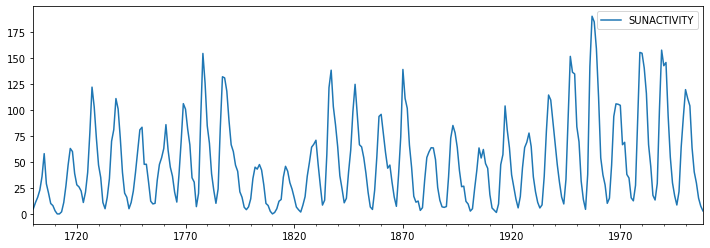

In [7]:
dta.plot(figsize=(12,4));

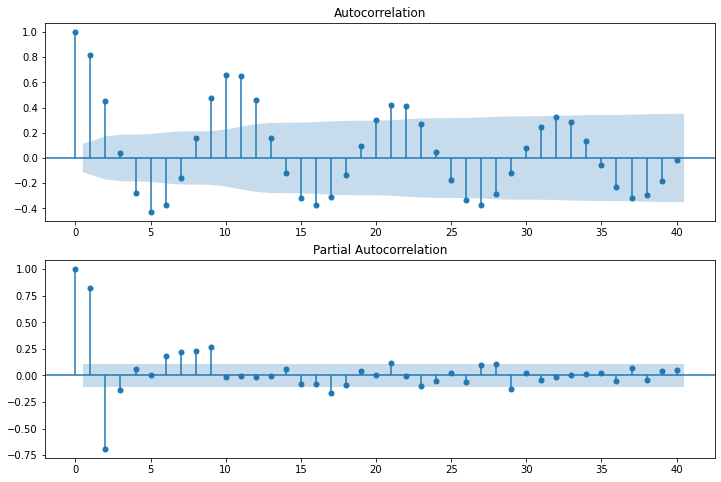

In [8]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta, lags=40, ax=ax2)

In [9]:
arma_mod20 = sm.tsa.statespace.SARIMAX(dta, order=(2,0,0), trend='c').fit(disp=False)
print(arma_mod20.params)

intercept     14.793947
ar.L1          1.390659
ar.L2         -0.688568
sigma2       274.761105
dtype: float64


In [10]:
arma_mod30 = sm.tsa.statespace.SARIMAX(dta, order=(3,0,0), trend='c').fit(disp=False)

In [11]:
print(arma_mod20.aic, arma_mod20.bic, arma_mod20.hqic)

2622.6363381415968 2637.5697032491876 2628.606725986843


In [12]:
print(arma_mod30.params)

intercept     16.762205
ar.L1          1.300810
ar.L2         -0.508122
ar.L3         -0.129612
sigma2       270.102651
dtype: float64


In [13]:
print(arma_mod30.aic, arma_mod30.bic, arma_mod30.hqic)

2619.4036296633903 2638.070336047879 2626.8666144699478


* Does our model obey the theory?

In [14]:
sm.stats.durbin_watson(arma_mod30.resid)

1.9564844832582977

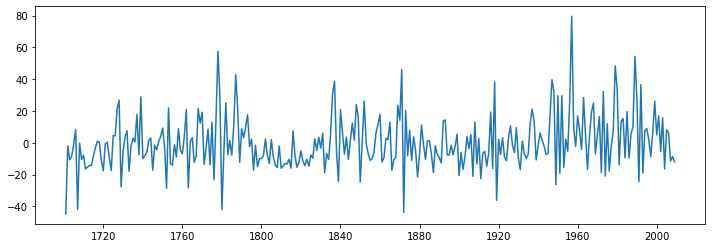

In [15]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
ax = plt.plot(arma_mod30.resid)

In [16]:
resid = arma_mod30.resid

In [17]:
stats.normaltest(resid)

NormaltestResult(statistic=49.84700616779215, pvalue=1.4992019587606612e-11)

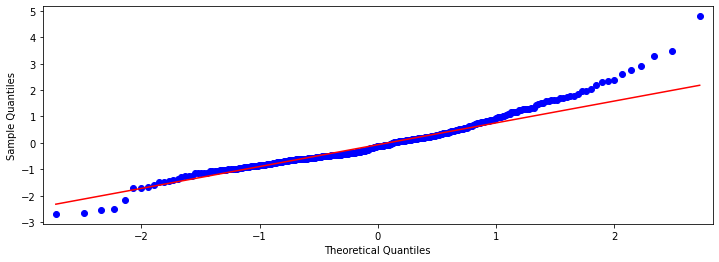

In [18]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)

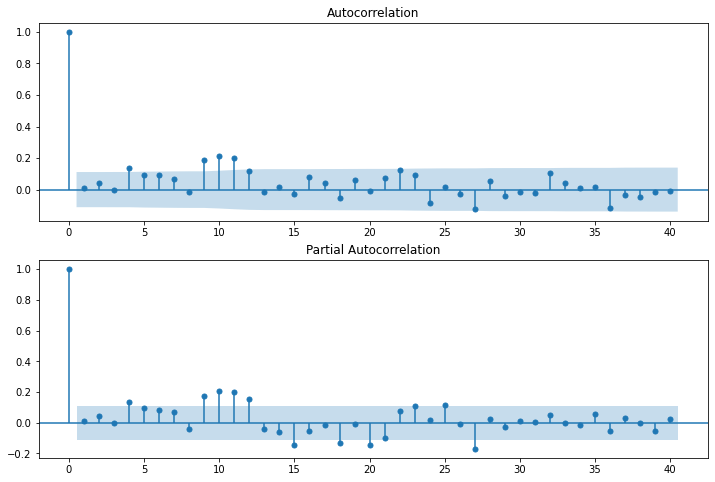

In [19]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

In [20]:
r,q,p = sm.tsa.acf(resid, fft=True, qstat=True)
data = np.c_[range(1,41), r[1:], q, p]
table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"])
print(table.set_index('lag'))

            AC          Q      Prob(>Q)
lag                                    
1.0   0.009176   0.026273  8.712350e-01
2.0   0.041820   0.573727  7.506142e-01
3.0  -0.001342   0.574292  9.022915e-01
4.0   0.136064   6.407488  1.707135e-01
5.0   0.092433   9.108334  1.048203e-01
6.0   0.091919  11.788018  6.686842e-02
7.0   0.068735  13.291375  6.531941e-02
8.0  -0.015021  13.363411  9.994248e-02
9.0   0.187599  24.636916  3.400197e-03
10.0  0.213724  39.317881  2.233182e-05
11.0  0.201092  52.358270  2.347759e-07
12.0  0.117192  56.802110  8.581666e-08
13.0 -0.014051  56.866210  1.895534e-07
14.0  0.015394  56.943403  4.001105e-07
15.0 -0.024986  57.147464  7.747084e-07
16.0  0.080892  59.293627  6.880520e-07
17.0  0.041120  59.850085  1.112486e-06
18.0 -0.052030  60.744064  1.550379e-06
19.0  0.062500  62.038495  1.833802e-06
20.0 -0.010292  62.073718  3.385223e-06
21.0  0.074467  63.924063  3.196544e-06
22.0  0.124962  69.152771  8.984833e-07
23.0  0.093170  72.069532  5.802915e-07


/home/travis/build/statsmodels/statsmodels/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,


* This indicates a lack of fit.

* In-sample dynamic prediction. How good does our model do?

In [21]:
predict_sunspots = arma_mod30.predict(start='1990', end='2012', dynamic=True)

<AxesSubplot:>

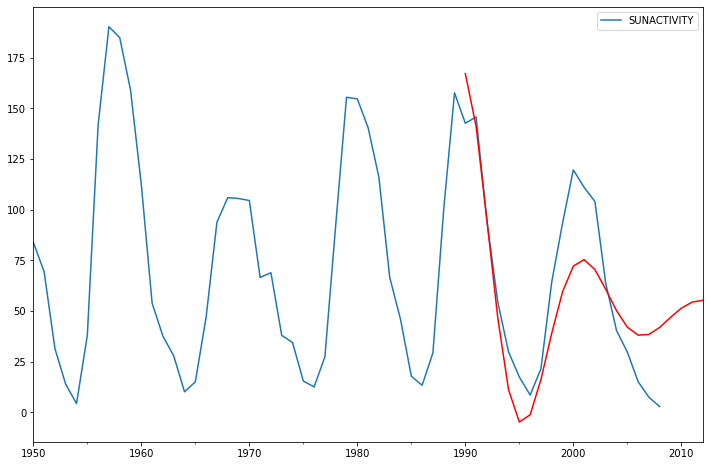

In [22]:
fig, ax = plt.subplots(figsize=(12, 8))
dta.loc['1950':].plot(ax=ax)
predict_sunspots.plot(ax=ax, style='r');

In [23]:
def mean_forecast_err(y, yhat):
    return y.sub(yhat).mean()

In [24]:
mean_forecast_err(dta.SUNACTIVITY, predict_sunspots)

5.635549951517733